In [25]:
%pip install pathlib tensorflow numpy matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os

2024-05-18 08:18:20.109459: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 08:18:20.119134: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 08:18:20.248720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 08:18:20.248886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 08:18:20.270354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [15]:
data = np.load('mnist.npz')
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu6'),
    tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu6'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')

    # ltsm
    #tf.keras.layers.Input(shape=(28, 28), name="input"),
    #tf.keras.layers.LSTM(20, return_sequences=True),
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(10, activation=tf.nn.softmax, name="output")
    
    # normal
    #tf.keras.layers.Flatten(input_shape=(28, 28)),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(10, activation='softmax')
])

# Train the digit classification model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    x_train,
    y_train,
    epochs=1,
    validation_data=(x_test, y_test)
)

/home/sullivan/dev/python/test/venv/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 8s 4ms/step - loss: 0.2119 - accuracy: 0.9367 - val_loss: 0.0819 - val_accuracy: 0.9759


In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# quant representative
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices((x_train)).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]
converter.representative_dataset = representative_data_gen
# enable int16 quant
# converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
# enable int8 quant
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# replacing inputs and outputs with uint8 types
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

# save and export
tflite_models_dir = pathlib.Path(".")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)
%ls -lht model.tflite
!xxd -i model.tflite > model.hpp


file_name = "model.hpp"
data1 = "#ifndef _MODEL_HPP_\r\n#define _MODEL_HPP_\r\nalignas(8) const "
data2 = "#endif"

with open(file_name, "r+") as f:
    old = f.read()
    f.seek(0)
    f.write(data1)
    f.write(old)
    f.write(data2)
    f.close()

#!cp model.hpp /home/sullivan/dev/cpp/test/test/include/model.hpp

INFO:tensorflow:Assets written to: /tmp/tmpb1eav2hp/assets


INFO:tensorflow:Assets written to: /tmp/tmpb1eav2hp/assets
/home/sullivan/dev/python/test/venv/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-18 09:08:00.856552: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-18 09:08:00.856604: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.


-rw-r--r-- 1 sullivan sullivan 24K May 18 09:08 model.tflite


2024-05-18 09:08:00.856770: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpb1eav2hp
2024-05-18 09:08:00.857610: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-18 09:08:00.857636: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpb1eav2hp
2024-05-18 09:08:00.860093: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-18 09:08:00.888445: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpb1eav2hp
2024-05-18 09:08:00.897977: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 41205 microseconds.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 11, Total Ops 24, % non-converted = 45.83 %
 * 11 ARITH ops

- arith.constant:   11 occurrences  (f32: 6, i32: 5)


In [31]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


[[0.00006251 0.00000007 0.0002024  0.00123734 0.00000004 0.00006052
  0.00000005 0.9983468  0.00001244 0.0000778 ]]


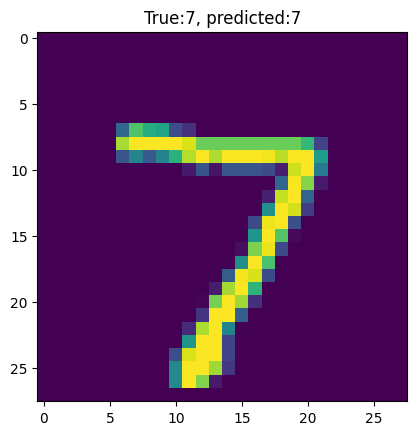

In [32]:
index_test_num = 0

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="mnist_model.tflite")
interpreter.allocate_tensors()

test_image = np.expand_dims(x_test[index_test_num], axis=0).astype(np.float32)
#input_dataww.shape=1,28,28

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)
np.set_printoptions(suppress=True)
print(predictions)

plt.imshow(x_test[index_test_num])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(y_test[index_test_num]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)
